# Thống kê máy tính và ứng dụng (Computational Statistics and Applications)

**Khoa Công nghệ Thông tin - ĐH Khoa học Tự nhiên TP. HCM ([fit@hcmus](https://www.fit.hcmus.edu.vn/))**

*Vũ Quốc Hoàng (vqhoang@fit.hcmus.edu.vn)*

# Bài 5 - Giới thiệu thống kê Bayes và Markov chain Monte Carlo

**Nội dung**

* [Công thức Bayes](#cong_thuc_Bayes)
* [Suy diễn Bayes](#suy_dien_Bayes)
* [Mô hình nhị thức](#mo_hinh_nhi_thuc)
* [“Tính” phân phối hậu nghiệm](#hau_nghiem)
* [Markov chain Monte Carlo](#MCMC)
  * [Thuật toán Metropolis-Hastings](#Metroplis_Hastings)
  * [Thuật toán bước ngẫu nhiên Metropolis](#random_Metropolis)
  * [Lấy mẫu Gibbs](#Gibbs)

In [61]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

## <a name="cong_thuc_Bayes"/>Công thức Bayes

### Ví dụ

Giả sử bạn đi xét nghiệm một bệnh nan y và được kết quả là *dương tính* (positive). Biết rằng
  * *Độ nhạy* (sensitive) của xét nghiệm là 90%: nghĩa là, trong 100 người bị bệnh thì khoảng 90 người cho kết quả xét nghiệm dương tính.
  * *Độ đặc hiệu* (specificity) của xét nghiệm là 95%: nghĩa là, trong 100 người không bệnh thì khoảng 95 người cho kết quả xét nghiệm âm tính.
  * *Độ phổ biến* (prevalence) của bệnh là 1/10000: nghĩa là, trong 10000 người thì có khoảng 1 người bị bệnh.

  a) Bạn nên chuẩn bị "hậu sự" không?
  
  b) Giả sử, để chắc ăn, bạn xét nghiệm một lần nữa và vẫn ra dương tính! Bạn nên chuẩn bị hậu sự chưa?
  
  c) Ta có nên xét nghiệm không? Ý nghĩa "thật sự" của việc xét nghiệm là gì?

### Trả lời

Đặt các biến cố:
* $D$ là "kết quả xét nghiệm dương tính"
* $B$ là "bị bệnh"

Các thông số của xét nghiệm:
* Độ nhạy hay **năng lực** (power):
  $$P(D|B) = 0.9$$
  Từ đó ta có: $P(D^c|B) = 1 - P(D|B) = 0.1$. Xác suất này thường được gọi là **tỉ lệ âm tính giả** (false negative rate) hay xác suất **sai lầm loại 2** (type II error), kí hiệu là $\beta$.
* Độ đặc hiệu:
  $$P(D^c|B^c) = 0.95$$
  Từ đó ta có: $P(D|B^c) = 1 - P(D^c|B^c) = 0.05$. Xác suất này thường được gọi là **tỉ lệ dương tính giả** (false positive rate) hay xác suất **sai lầm loại 1** (type I error) hay **mức ý nghĩa** (significance level), kí hiệu là $\alpha$.

*Lưu ý*:
* Ta dễ dàng có độ nhạy hay độ đặc hiệu tốt riêng lẻ (chẳng hạn, xét nghiệm luôn báo dương tính sẽ có độ nhạy là 100%) nhưng không thể đồng thời tốt cả 2.
* Tùy trường hợp mà ta ưu tiên độ nhạy hay độ đặc hiệu hơn. Thông thường, độ đặc hiệu thường được quan tâm hơn vì rất nguy hiểm khi báo dương tính sai (như xét nghiệm HIV, báo dương tính sai sẽ dẫn đến suy sụp). Ngược lại, độ nhạy được quan tâm hơn khi việc báo âm tính sai để lại hậu quả lớn (như xét nghiệm COVID-19, báo âm tính sai sẽ dẫn đến lây lan).

In [11]:
P_DB = 90/100; P_DcBc = 95/100

a) Đề cho độ phổ biến của bệnh là $10^{-4}$. Ta có thể dùng tỉ lệ này để "ước tính" xác suất bị bệnh khi chưa thực hiện xét nghiệm, gọi là xác suất tiên nghiệm:
$$P(B) = 0.0001$$
Từ đó ta cũng có: $P(B^c) = 1 - P(B) = 0.9999$.

Dùng công thức Bayes, ta có xác suất bị bệnh khi xét nghiệm dương tính, gọi là xác suất hậu nghiệm:
\begin{align*}
    P(B|D) &= \frac{P(B)P(D|B)}{P(B)P(D|B) + P(B^c)P(D|B^c)}\\
           &= \frac{0.0001 \times 0.9}{0.0001 \times 0.9 + 0.9999 \times 0.05}
\end{align*}

In [12]:
P_B = 1/10**4
P_BD = P_B*P_DB/(P_B*P_DB + (1 - P_B)*(1 - P_DcBc))
print("%.4f" % P_BD)

0.0018


*Nhận xét*: xác suất này "không lớn lắm".

b) Trước khi tiến hành xét nghiệm lần 2 ta đã có xác suất hậu nghiệm sau khi xét nghiệm lần 1. Ta có thể dùng xác suất này để "ước tính" xác suất bị bệnh khi chưa thực hiện xét nghiệm lần 2 (tức là dùng xác suất hậu nghiệm của lần 1 làm tiên nghiệm của lần 2):
$$P(B) = 0.0018$$
Từ đó ta cũng có: $P(B^c) = 1 - P(B) = 0.9982$.

Dùng công thức Bayes, ta có xác suất bị bệnh khi xét nghiệm dương tính lần 2 là:
\begin{align*}
    P(B|D) &= \frac{P(B)P(D|B)}{P(B)P(D|B) + P(B^c)P(D|B^c)}\\
           &= \frac{0.0018 \times 0.9}{0.0018 \times 0.9 + 0.9982 \times 0.05}
\end{align*}

In [13]:
P_B2 = P_BD
P_BD2 = P_B2*P_DB/(P_B2*P_DB + (1 - P_B2)*(1 - P_DcBc))
print("%.4f" % P_BD2)

0.0314


*Nhận xét*: xác suất này "cũng chưa lớn lắm".

c) Việc có nên xét nghiệm hay không tùy thuộc trước hết vào xác suất tiên nghiệm ($P(B)$) của bệnh.

* Trường hợp xác suất tiên nghiệm thấp: như ta "không làm gì để nghi nhiễm HIV" hay không nằm trong nhóm nguy cơ cao nhiễm COVID-19 (không về từ vùng dịch, không tiếp xúc với người đã nhiễm bệnh) thì không nên xét nghiệm như tính toán trên cho thấy. Việc xét nghiệm tốn kém và thậm chí là "tiền mất tật mang" nếu xét nghiệm có tỉ lệ dương tính giả cao (tức là độ đặc hiệu thấp).

* Trường hợp xác suất tiên nghiệm cao: như ta vừa phơi nhiễm HIV hay nằm trong nhóm nguy cơ cao nhiễm COVID-19 thì nên xét nghiệm. Chẳng hạn, với xác suất tiên nghiệm $P(B) = 50\%$ thì xác suất hậu nghiệm, $P(B|D)$ là:

In [14]:
P_B = 50/100
P_BD = P_B*P_DB/(P_B*P_DB + (1 - P_B)*(1 - P_DcBc))
print("%.4f" % P_BD)

0.9474


*Nhận xét*: xác suất này rất cao!

Ý nghĩa của xét nghiệm không chỉ nằm ở trường hợp ra dương tính. Trường hợp ra âm tính cũng rất có ý nghĩa. Chẳng hạn, ta nằm trong nhóm nguy cơ cao nhiễm COVID-19 với xác suất tiên nghiệm $P(B) = 50\%$. Với các thông số của xét nghiệm như trên và xét nghiệm ra âm tính, xác suất hậu nghiệm khi đó là:
$$P(B|D^c) = \frac{P(B)P(D^c|B)}{P(B)P(D^c|B) + P(B^c)P(D^c|B^c)}$$

In [15]:
P_B = 50/100
P_BDc = P_B*(1 - P_DB)/(P_B*(1 - P_DB) + (1 - P_B)*P_DcBc)
print("%.4f" % P_BDc)

0.0952


*Nhận xét*: xác suất này "thấp".

Thật ra, với tình hình COVID-19 hiện nay ở nước ta (ít dụng cụ xét nghiệm, rất ít người nhiễm và nếu không cách ly người nhiễm sẽ làm lây lan rất nhiều) thì ta nên dùng xét nghiệm có độ nhạy cao (chấp nhận giảm độ đặc hiệu), ưu tiên xét nghiệm những người có nguy cơ cao và chú trọng đến kết quả âm tính.

Chẳng hạn dùng xét nghiệm có:
* Độ nhạy: $P(D|B) = 99.9\%$
* Độ đặc hiệu: $P(D^c|B^c) = 80\%$

Người có nguy cơ nhiễm cao với $P(B) = 50\%$, khi xét nghiệm ra âm tính, thì xác suất bị nhiễm $P(B|D^c)$ là

In [16]:
P_DB = 99.9/100; P_DcBc = 80/100
P_B = 50/100
P_BDc = P_B*(1 - P_DB)/(P_B*(1 - P_DB) + (1 - P_B)*P_DcBc)
print("%.4f" % P_BDc)

0.0012


*Nhận xét*: xác suất này khá thấp!

Để chắc ăn hơn, ta xét nghiệm lần nữa và nếu vẫn âm tính thì xác suất bị nhiễm khi đó là:

In [17]:
P_B2 = P_BDc
P_BDc2 = P_B2*(1 - P_DB)/(P_B2*(1 - P_DB) + (1 - P_B2)*P_DcBc)
print("%.8f" % P_BDc2)

0.00000156


*Nhận xét*: xác suất này rất thấp!

Để chắc ăn hơn nữa, ta xét nghiệm lần 3 và nếu vẫn âm tính thì xác suất bị nhiễm khi đó là:

In [18]:
P_B3 = P_BDc2
P_BDc3 = P_B3*(1 - P_DB)/(P_B3*(1 - P_DB) + (1 - P_B3)*P_DcBc)
print("%.10f" % P_BDc3)

0.0000000020


*Nhận xét*: xác suất này cực thấp!

## <a name="suy_dien_Bayes"/>Suy diễn Bayes

### Ví dụ

In [46]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])

def posterior(sigma2):
    likelihood = np.exp(-np.sum((x - np.reshape(mu, (-1, 1)))**2, axis=1)/(2*sigma2))
    likelihood_prior = likelihood * prior
    return likelihood_prior/np.sum(likelihood_prior)

In [60]:
sigma2 = [1, 1.35, 2]
pd.DataFrame({"$\sigma^2 = %.2f$" % s2: np.round(posterior(s2), 4) for s2 in sigma2},
             index=["$P(\mu= %.1f|D)$" % m for m in mu])


,$\sigma^2 = 1.00$,$\sigma^2 = 1.35$,$\sigma^2 = 2.00$
$P(\mu= 1.0|D)$,0.0706,0.1100,0.1583
$P(\mu= 2.0|D)$,0.6369,0.5612,0.4754
$P(\mu= 3.0|D)$,0.2862,0.3103,0.3187
$P(\mu= 4.0|D)$,0.0064,0.0186,0.0477


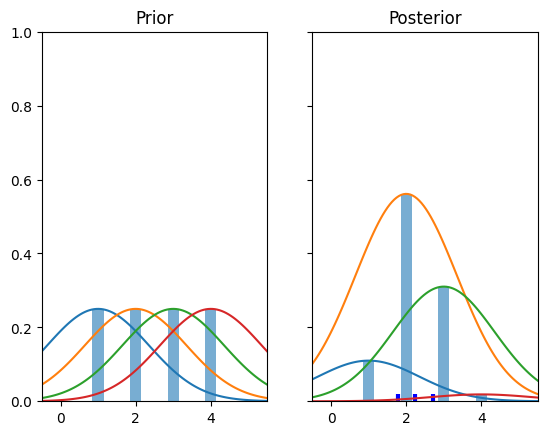

In [21]:
def plot_prior_post(sigma2):
    x_min, x_max = np.min(mu) - 1.5, np.max(mu) + 1.5
    t = np.linspace(x_min, x_max, 100)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.set_title("Prior")
    ax1.bar(mu, prior, width=0.3, alpha=0.6)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 1)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax1.plot(t, prior[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    
    post = posterior(sigma2)
    
    ax2.set_title("Posterior")
    ax2.bar(mu, post, width=0.3, alpha=0.6)
    ax2.set_xlim(x_min, x_max)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax2.plot(t, post[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    ax2.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3)
    plt.show()
    
plot_prior_post(1.35)

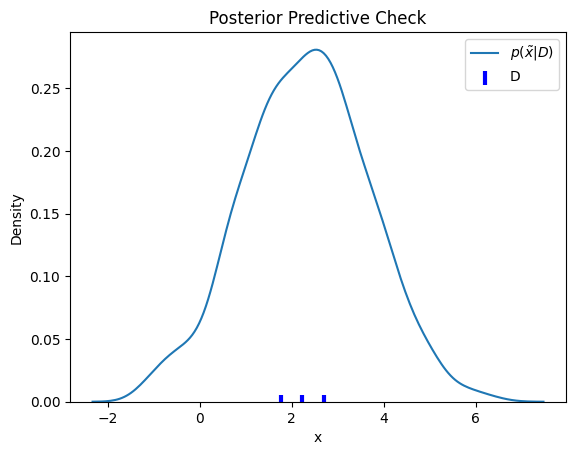

In [22]:
def posterior_predictive_check(sigma2, N):
    post = posterior(sigma2)
    mu_post_sample = np.random.choice(mu, size=N, p=post)
    x_post_sample = np.random.normal(mu_post_sample, np.sqrt(sigma2), size=N)
    sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
    plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
    plt.legend()
    plt.title("Posterior Predictive Check")
    plt.xlabel("x")
    plt.show()
    
posterior_predictive_check(1.35, 1000)

## <a name="mo_hinh_nhi_thuc"/>Mô hình nhị thức

### Ví dụ

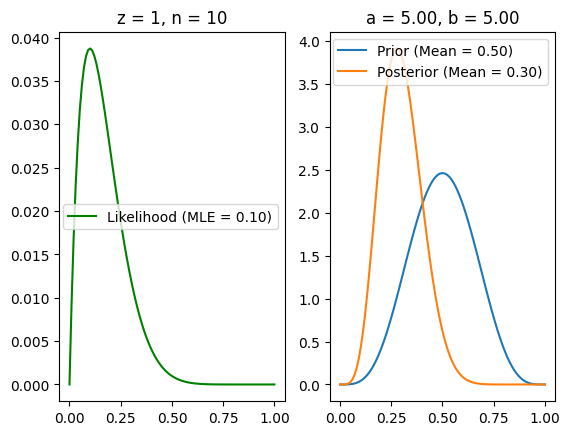

In [23]:
a, b = 5, 5
z, n = 1, 10

theta = np.linspace(0, 1, 100)
likelihood = theta**z * (1 - theta)**(n - z)
prior_dist = stats.beta(a, b)
posterior_dist = stats.beta(a + z, b + n - z)
prior = prior_dist.pdf(theta)
posterior = posterior_dist.pdf(theta)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label="Likelihood (MLE = %.2f)" % (z/n))
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label="Prior (Mean = %.2f)" % prior_dist.mean())
ax2.plot(theta, posterior, label="Posterior (Mean = %.2f)" % posterior_dist.mean())
ax2.set_title("a = %.2f, b = %.2f" % (a, b))
ax2.legend()
plt.show()

## <a name="hau_nghiem"/>“Tính” phân phối hậu nghiệm

### Phân phối tiên nghiệm liên hợp

[Conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)

### Xấp xỉ lưới

In [24]:
def local_max(x):
    local_max = []
    inc = True
    for i in range(len(x) - 1):
        if inc and x[i + 1] < x[i]:
            local_max.append(i)
            inc = False
        elif not inc and x[i + 1] > x[i]:
            inc = True
    return local_max

Mô hình nhị thức với phân phối tiên nghiệm 2 đỉnh (mode) dùng “xấp xỉ lưới”

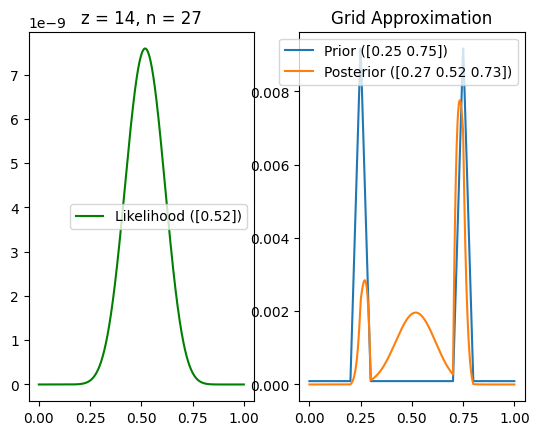

In [25]:
#z, n = 1, 10
z, n = 14, 27

theta = np.linspace(0, 1, 1000) # 1000-points grid

likelihood = theta**z * (1 - theta)**(n - z)
mle = np.round(theta[local_max(likelihood)], 2)

prior = np.concatenate((np.repeat(1,200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200),
                        np.repeat(1, 200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200)))
#prior = np.concatenate((np.linspace(1, 500, 500), np.linspace(500, 1, 500)))
prior = prior/np.sum(prior)
prior_modes = np.round(theta[local_max(prior)], 2)

posterior = likelihood * prior
posterior = posterior/np.sum(posterior)
posterior_modes = np.round(theta[local_max(posterior)], 2)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label=f"Likelihood ({mle})")
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label=f"Prior ({prior_modes})")
ax2.plot(theta, posterior, label=f"Posterior ({posterior_modes})")
ax2.set_title("Grid Approximation")
ax2.legend()

plt.show()

### Lấy mẫu loại bỏ

In [26]:
# Algorithm ERS
# Input:
#   N: output sequence length
#   f: the non-normalised target density
#   gs: sampler for the proposal density
#   g: the proposal density
#   c > 0: such that f(x) <= c g(x) for all x
# Output: a tuple (X, T)
#   X: sequence X1, X2, X3, . . . iid with density f tiddle
#   T: total number of proposals
def ESR(N, f, gs, g, c):
    T = 0
    X = []
    i = 0
    while i < N:
        T = T + 1
        Xn = gs()
        Un = np.random.uniform(size=1)
        if c*g(Xn)*Un <= f(Xn):
            i = i + 1
            X.append(Xn)

    return (np.array(X), T)

Acceptance rate (Z): 0.5721
Mean: 0.7150834466451815
Variance: 0.628833583272315


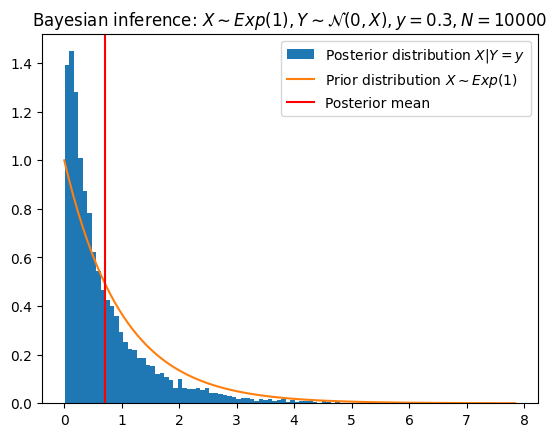

In [27]:
np.random.seed(2022)

N = 10000
y = 0.3

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

plt.show()

Acceptance rate (Z): 0.3458
Mean: 1.951797830036798
Variance: 1.2603030367570411


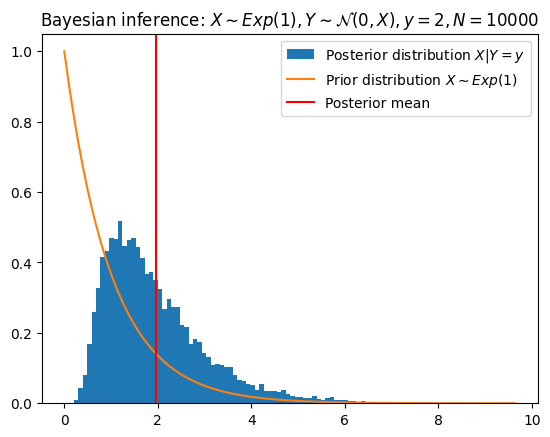

In [28]:
np.random.seed(2022)

N = 10000
y = 2

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

plt.show()

## <a name="MCMC"/>Markov chain Monte Carlo

### <a name="Metroplis_Hastings"/>Thuật toán Metropolis-Hastings

In [29]:
def MH_Example1(N, X0=0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        Xp = Xn + np.random.choice([-1, 1])
        if np.random.uniform() <= 2.0**(abs(Xn) - abs(Xp)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

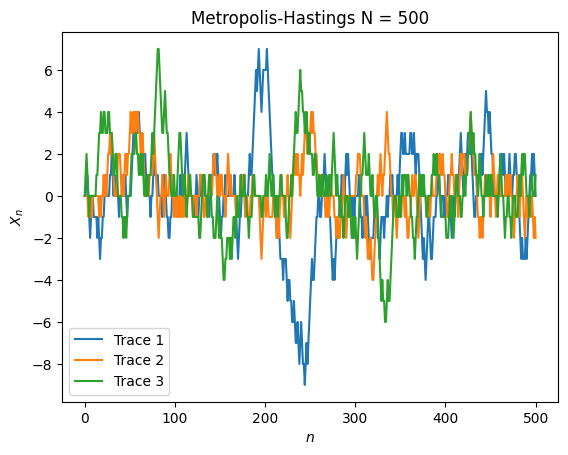

In [30]:
N = 500
traces = [MH_Example1(N, X0=0) for _ in range(3)]

for i, trace in enumerate(traces):
    plt.plot(range(N + 1), trace, label=f"Trace {i + 1}")
plt.legend()
plt.xlabel("$n$")
plt.ylabel("$X_n$")
plt.title(f"Metropolis-Hastings N = {N}")
plt.show()

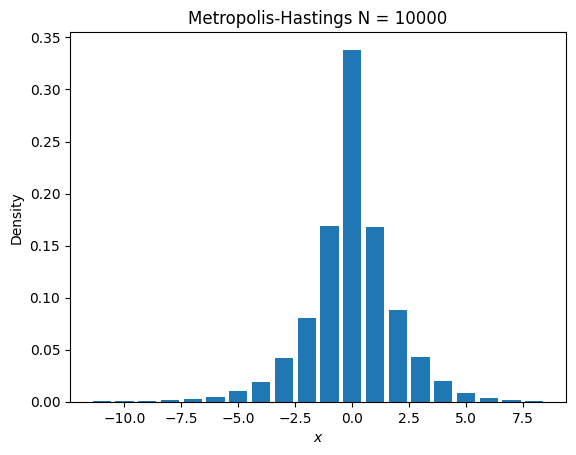

In [31]:
N = 10000
trace = MH_Example1(N, X0=0)
values, counts = np.unique(trace, return_counts=True)

plt.bar(values, counts/N)
plt.title(f"Metropolis-Hastings N = {N}")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.show()

### <a name="random_Metropolis"/>Thuật toán bước ngẫu nhiên Metropolis

In [32]:
def RW_MEtropolis(N, f, sigma, X0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        ep = np.random.normal(0, sigma)
        Xp = Xn + ep
        if np.random.uniform() <= min(1, f(Xp)/f(Xn)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

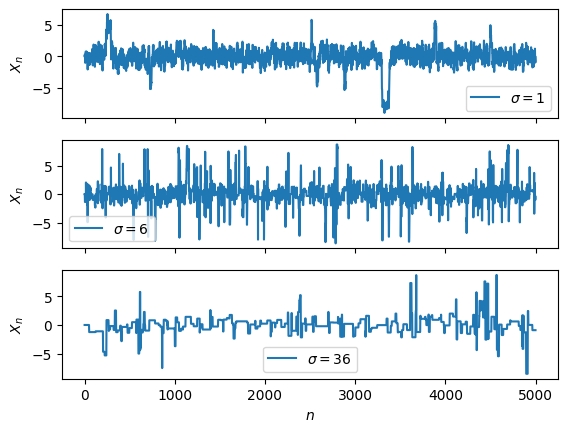

In [33]:
def f(x):
    return math.sin(x)**2/(x**2) * (-3*math.pi <= x <= 3*math.pi)

N = 5000
sigmas = [1, 6, 36]
traces = [RW_MEtropolis(N, f, s2, 0.001) for s2 in sigmas]

_, axs = plt.subplots(len(traces), 1, sharex=True)
for i, trace in enumerate(traces):
    axs[i].plot(range(N + 1), trace, label=f"$\sigma = {sigmas[i]}$")
    axs[i].set_ylabel("$X_n$")
    axs[i].legend()
plt.xlabel("$n$")
plt.show()

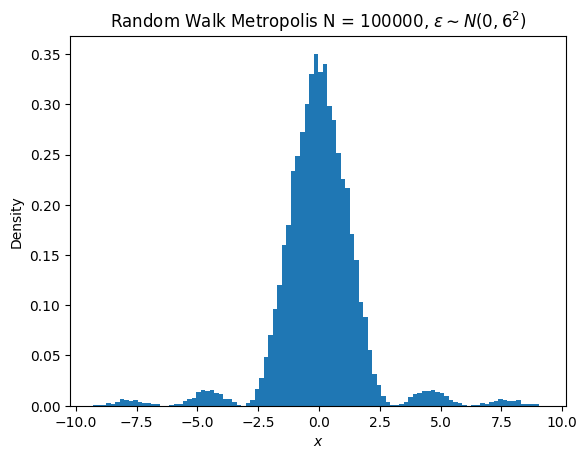

In [34]:
N = 100000
sigma= 6
trace = RW_MEtropolis(N, f, sigma, 0.001)

plt.hist(trace, density=True, bins=100)
plt.title(f"Random Walk Metropolis N = {N}, $\epsilon \sim N(0, {sigma}^2)$")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.show()

### <a name="Gibbs"/>Lấy mẫu Gibbs

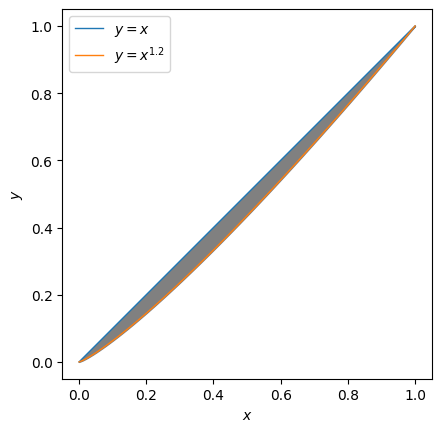

In [35]:
x = np.linspace(0, 1, 100)

plt.fill_between(x, x, x**1.2, color="gray")
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [36]:
def reject_uniform(N):
    xy = []
    T = 0
    i = 0
    while i < N:
        T = T + 1
        Xn, Yn = np.random.uniform(0, 1, size=2)
        if Xn**1.2 <= Yn <= Xn:
            i = i + 1
            xy.append((Xn, Yn))
    return (np.array(xy), T)

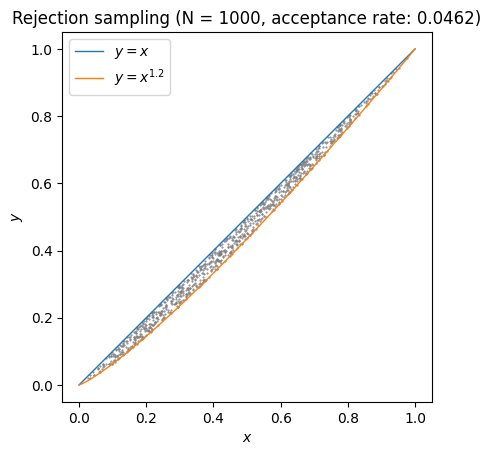

In [37]:
N = 1000
xy, T = reject_uniform(N)

plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Rejection sampling (N = {N}, acceptance rate: {round(N/T, 4)})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [38]:
def Gibbs_uniform(N):
    xy = []
    x, y = 0.5, 0.5
    for _ in range(N):
        x = np.random.uniform(y, y**(1/1.2))
        y = np.random.uniform(x**1.2, x)
        xy.append((x, y))
    return np.array(xy)

def get_partial_xy(xy, k):
    x, y = [xy[0, 0]], [xy[0, 1]]
    for i in range(1, k):
        x += [xy[i, 0], xy[i, 0]]
        y += [xy[i-1, 1], xy[i, 1]]
    return x, y

N = 1000
xy = Gibbs_uniform(N)

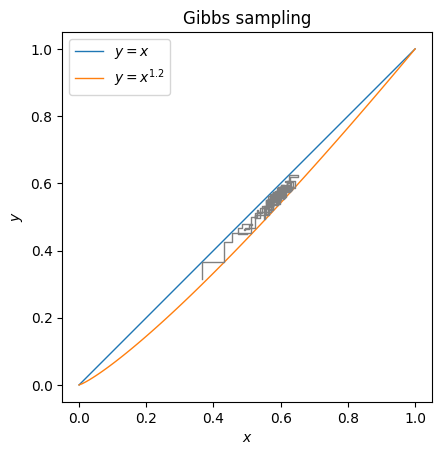

In [39]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.plot(*get_partial_xy(xy, 100), color="gray", linewidth=1)
plt.title(f"Gibbs sampling")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

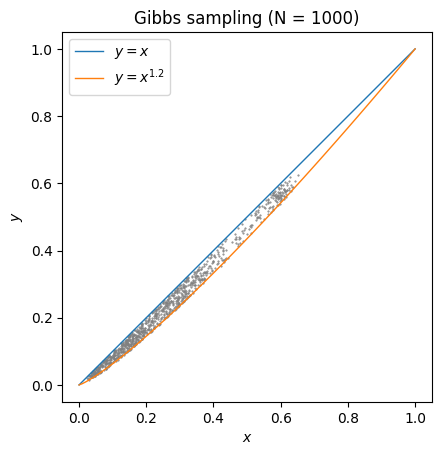

In [40]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Gibbs sampling (N = {N})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()